# NYPD Crime Reports Dataset

This notebook explores and analyzes the New York Police Department (NYPD) crimes report dataset which contains all valid felony, misdemeanor, and violation crimes reported in New York City from 2006 to 2022.

The dataset includes about 8 million crimes reported.

The dataset is available at:
https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i

## Attribute Description

| Column | Description | Data Type
|--------|-------------------|----|
| CMPLNT_NUM | Randomly generated persistent ID for each complaint  | bigint(20) |
| CMPLNT_FR | Exact datetime of occurrence for the reported event (or starting date of occurrence, if CMPLNT_TO_DT exists) | datetime |
| CMPLNT_TO | Ending datetime of occurrence for the reported event, if exact time of occurrence is unknown | datetime
| RPT_DT | Date event was reported to police  | date
| KY_CD | Three digit offense classification code | char(3)
| PD_CD | Three digit internal classification code (more granular than Key Code) | char(3)
| JURISDICTION_CODE	| | smallint(6)
| CRM_ATPT_CPTD_CD | Indicator of whether crime was successfully completed or attempted, but failed or was interrupted prematurely | enum('COMPLETED','ATTEMPTED')
| LAW_CAT_CD | Level of offense: felony, misdemeanor, violation  | enum('FELONY','MISDEMEANOR','VIOLATION')
| BORO_NM | The name of the borough in which the incident occurred | enum('BRONX','BROOKLYN','MANHATTAN','QUEENS','STATEN ISLAND')
| ADDR_PCT_CD | The precinct in which the incident occurred | char(3)
| LOC_OF_OCCUR_DESC | Specific location of occurrence in or around the premises; inside, opposite of, front of, rear of | enum('FRONT OF','INSIDE','OPPOSITE OF','OUTSIDE','REAR OF')
| PATROL_BORO | |	enum('PATROL BORO BRONX','PATROL BORO BKLYN SOUTH','PATROL BORO BKLYN NORTH','PATROL BORO MAN SOUTH','PATROL BORO MAN NORTH','PATROL BORO QUEENS NORTH','PATROL BORO QUEENS SOUTH','PATROL BORO STATEN ISLAND')
| PREM_TYP_DESC | Specific description of premises; grocery store, residence, street, etc. | varchar(80)
| SUSP_RACE  | |		enum('UNKNOWN','BLACK','WHITE','WHITE HISPANIC','ASIAN / PACIFIC ISLANDER','BLACK HISPANIC','AMERICAN INDIAN/ALASKAN NATIVE')
| VIC_RACE  | |		enum('UNKNOWN','BLACK','WHITE','WHITE HISPANIC','ASIAN / PACIFIC ISLANDER','BLACK HISPANIC','AMERICAN INDIAN/ALASKAN NATIVE')
| SUSP_AGE_GROUP  | |		enum('<18','18-24','25-44','45-64','65+')
| VIC_AGE_GROUP  | |		enum('<18','18-24','25-44','45-64','65+')
| SUSP_SEX  | |		enum('M','F')
| VIC_SEX  | |	enum('M','F','E','D')
| Latitude | Latitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326)  | double
| Longitude | Longitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326) | double

---

**Auxiliary Tables**:

There are three auxiliary tables `jurisdiction_codes`, `offense_codes`, `penal_codes`, which provide descriptions for the `JURISDICTION_CODE`, `KY_CD`, and `PD_CD` attributes of the main table.


**Additional Notes**: https://www1.nyc.gov/assets/nypd/downloads/pdf/analysis_and_planning/incident_level_data_footnotes.pdf



## MySQL Database

The dataset is stored on a private MySQL Server.

To access without the credentials for this server, the dataset is publically available at nyc.gov.

In [152]:
# Installing packages
!sudo pip3 install  -U -q geopandas PyMySQL sqlalchemy sql_magic

In [153]:
# Libraries
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import text
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

In [154]:
######################################
##    HIDE SECTION BEFORE COMMIT   ###
######################################

# Credentials to access server
username = 'student'
password = 'dwdstudent2015'
host = 'db.ipeirotis.org'

# Credentials to access server
#username = 'Enter_Username'
#password = 'Enter_Password'
#host = 'Enter_Host'

# Accessing MySQL server.
conn_string = 'mysql+pymysql://{user}:{password}@{host}:{port}/{db}?charset={encoding}'.format(
    user= username,
    password= password,
    host = host,
    port=3306,
    db='nypd',
    encoding = 'utf8'
)
engine = create_engine(conn_string)

# Analysis
Using a combination of SQL and Python, the following analysis answered 5 key questions.



### 1. Composition of crimes:
  *   How many reported crimes are in the dataset?
  *   Breakdown reported crimes amoung Felony, Misdemeanor, and Violation.
  *   Amoung Felonies, what are the top-10 most reported crimes?

### 2. Trends in crime over time:

  *  Trend in total number of all reported crimes per year.
  *  Trend in total number of all reported crimes per month.

### 3. Analysis of the major felonies.
  * The major felonies are: Grand Larceny, Robbery, Felony Assault, Burglary, Grand Larceny of Motor Vehicle, Rape.
  * Reporting the number of these crimes over time broken down by felony type.

### 4. The major felonies based on hour of the day.
  * The major felonies by hour of the day.
  * The major felonies by hour, Normalized to allow for easier comparison.

### 5. Spacial Analysis
  * Where in NYC are these crimes being committed?
  * Density plot (over NYC map) for each major felony.


## 1. Composition of crimes:


In [155]:
# How many total reported crimes are in the data

sql = '''
	SELECT COUNT(CMPLNT_NUM)
	FROM nypd;
'''
with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

,COUNT(CMPLNT_NUM)
0,8324108


In [156]:
# Analyzing the column LAW_CAT_CD to report the number of felonies, misdemeanors, and violations.

sql = '''
	SELECT LAW_CAT_CD AS Crime, COUNT(LAW_CAT_CD) AS num_crimes
	FROM nypd
	GROUP BY LAW_CAT_CD
	ORDER BY num_crimes DESC;

'''

with engine.connect() as connection:
	df2 = pd.read_sql(text(sql), con=connection)

df2

,Crime,num_crimes
0,MISDEMEANOR,4616116
1,FELONY,2590234
2,VIOLATION,1117758


In [157]:
# Defining chart attributes
chartcolor = "#4E79A7"
chartcolor2 = "#053661"
chartcolor_hunter = "#589d62"
chartcolor_hunter2 = "#467c4e"
chartcolor_gray = "#5a5a5a"
caption_text = "Data Source: NYPD (2006-2022) | Willy Feid"

**Plotting Crime Reports by Type**

---

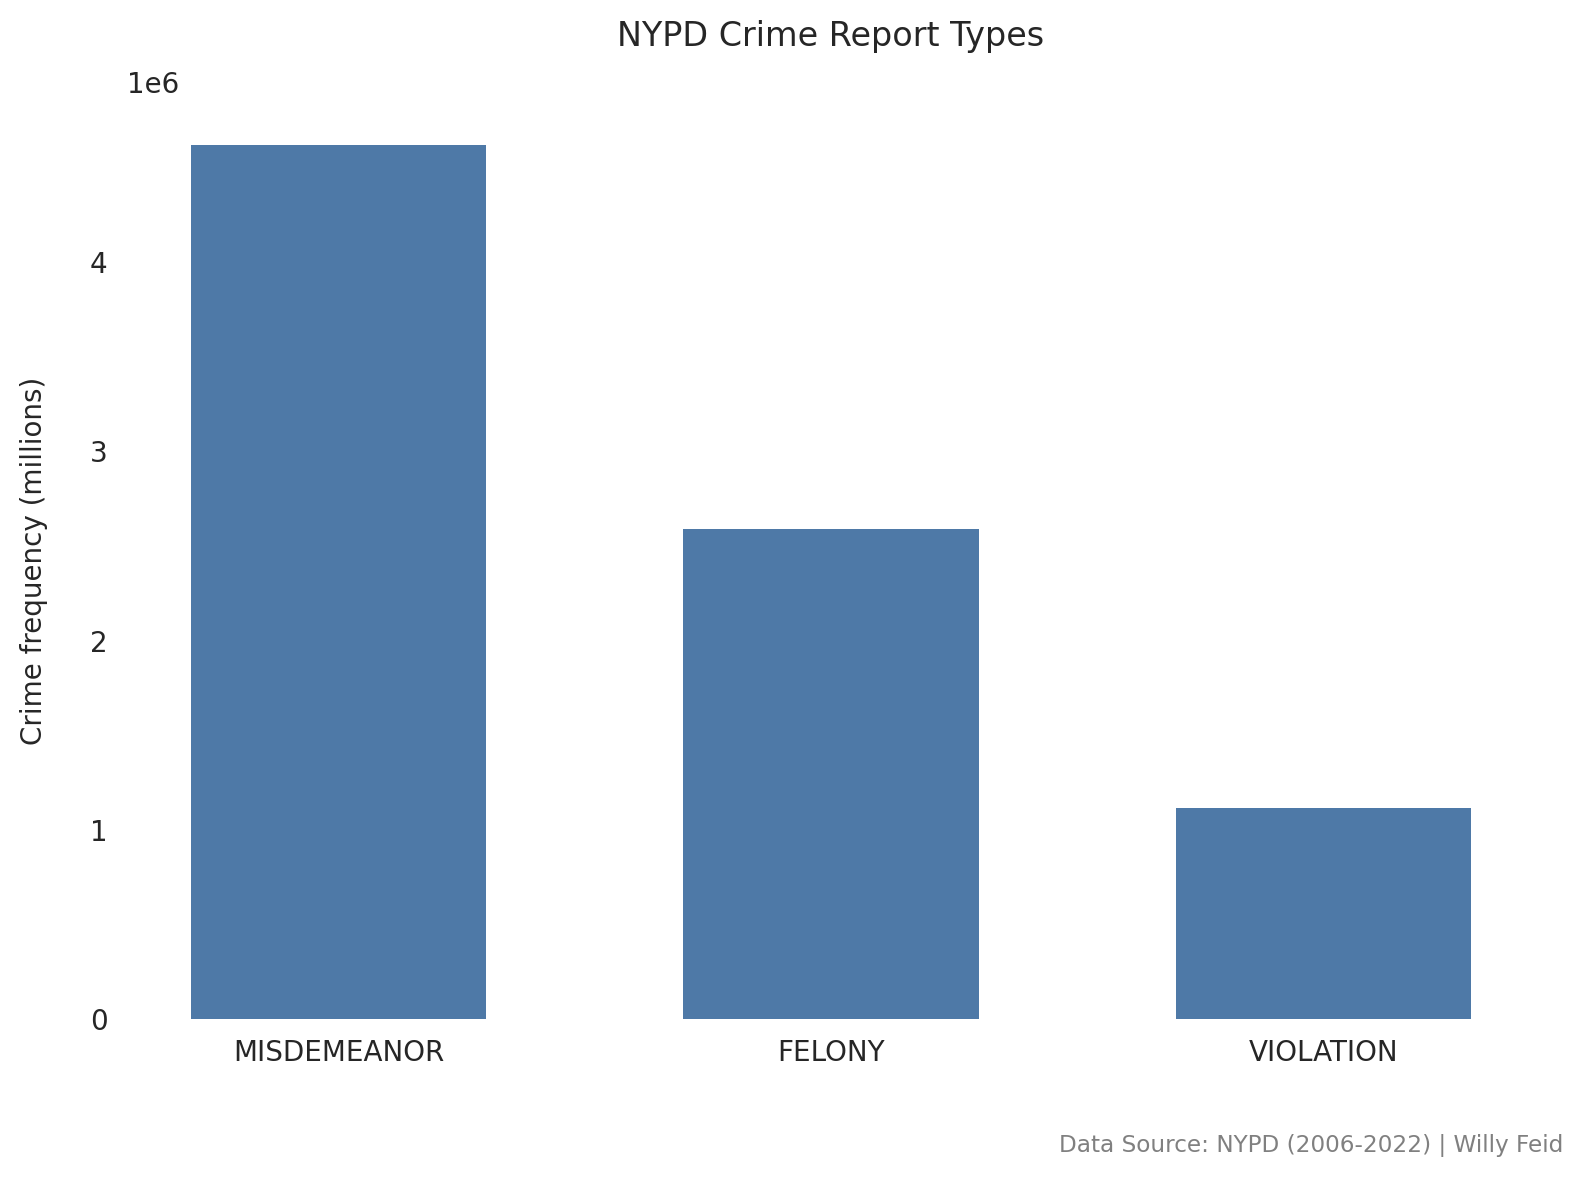

In [158]:
# Plotting the 3 crime types.

# Set the style
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(df2['Crime'], df2['num_crimes'], width=0.6, color=chartcolor, edgecolor='none')

# removing fig box
for spine in ax.spines.values():
  spine.set_visible(False)

ax.tick_params(bottom=False, left=False)  # Remove the ticks
ax.set_xlabel("")
ax.set_ylabel("Crime frequency (millions)", labelpad=15)
ax.set_title("NYPD Crime Report Types", pad=20)

ax.text(1.02, -0.15, caption_text, transform=ax.transAxes, fontsize='small', color='gray', ha='right', va='bottom')
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle='-', linewidth=0.7, color='white') #thin white grid lines

plt.tight_layout()

plt.show()

**Exploring Felony crimes by offense description**

---


In [159]:
# Breaking down Felony crimes by the offense description.
sql = '''
	SELECT OFNS_DESC, COUNT(LAW_CAT_CD) AS num_crimes
	FROM offense_codes
		INNER JOIN nypd ON offense_codes.KY_CD = nypd.KY_CD
	WHERE LAW_CAT_CD = 'FELONY'
	GROUP BY OFNS_DESC
	ORDER BY num_crimes DESC
	LIMIT 10;
'''

with engine.connect() as connection:
	df3 = pd.read_sql(text(sql), con=connection)

df3

,OFNS_DESC,num_crimes
0,GRAND LARCENY,731094
1,FELONY ASSAULT,334974
2,ROBBERY,297214
3,BURGLARY,282750
4,MISCELLANEOUS PENAL LAW,203377
5,GRAND LARCENY OF MOTOR VEHICLE,157358
6,CRIMINAL MISCHIEF & RELATED OF,151625
7,DANGEROUS DRUGS,92152
8,THEFT-FRAUD,83226
9,FORGERY,82429


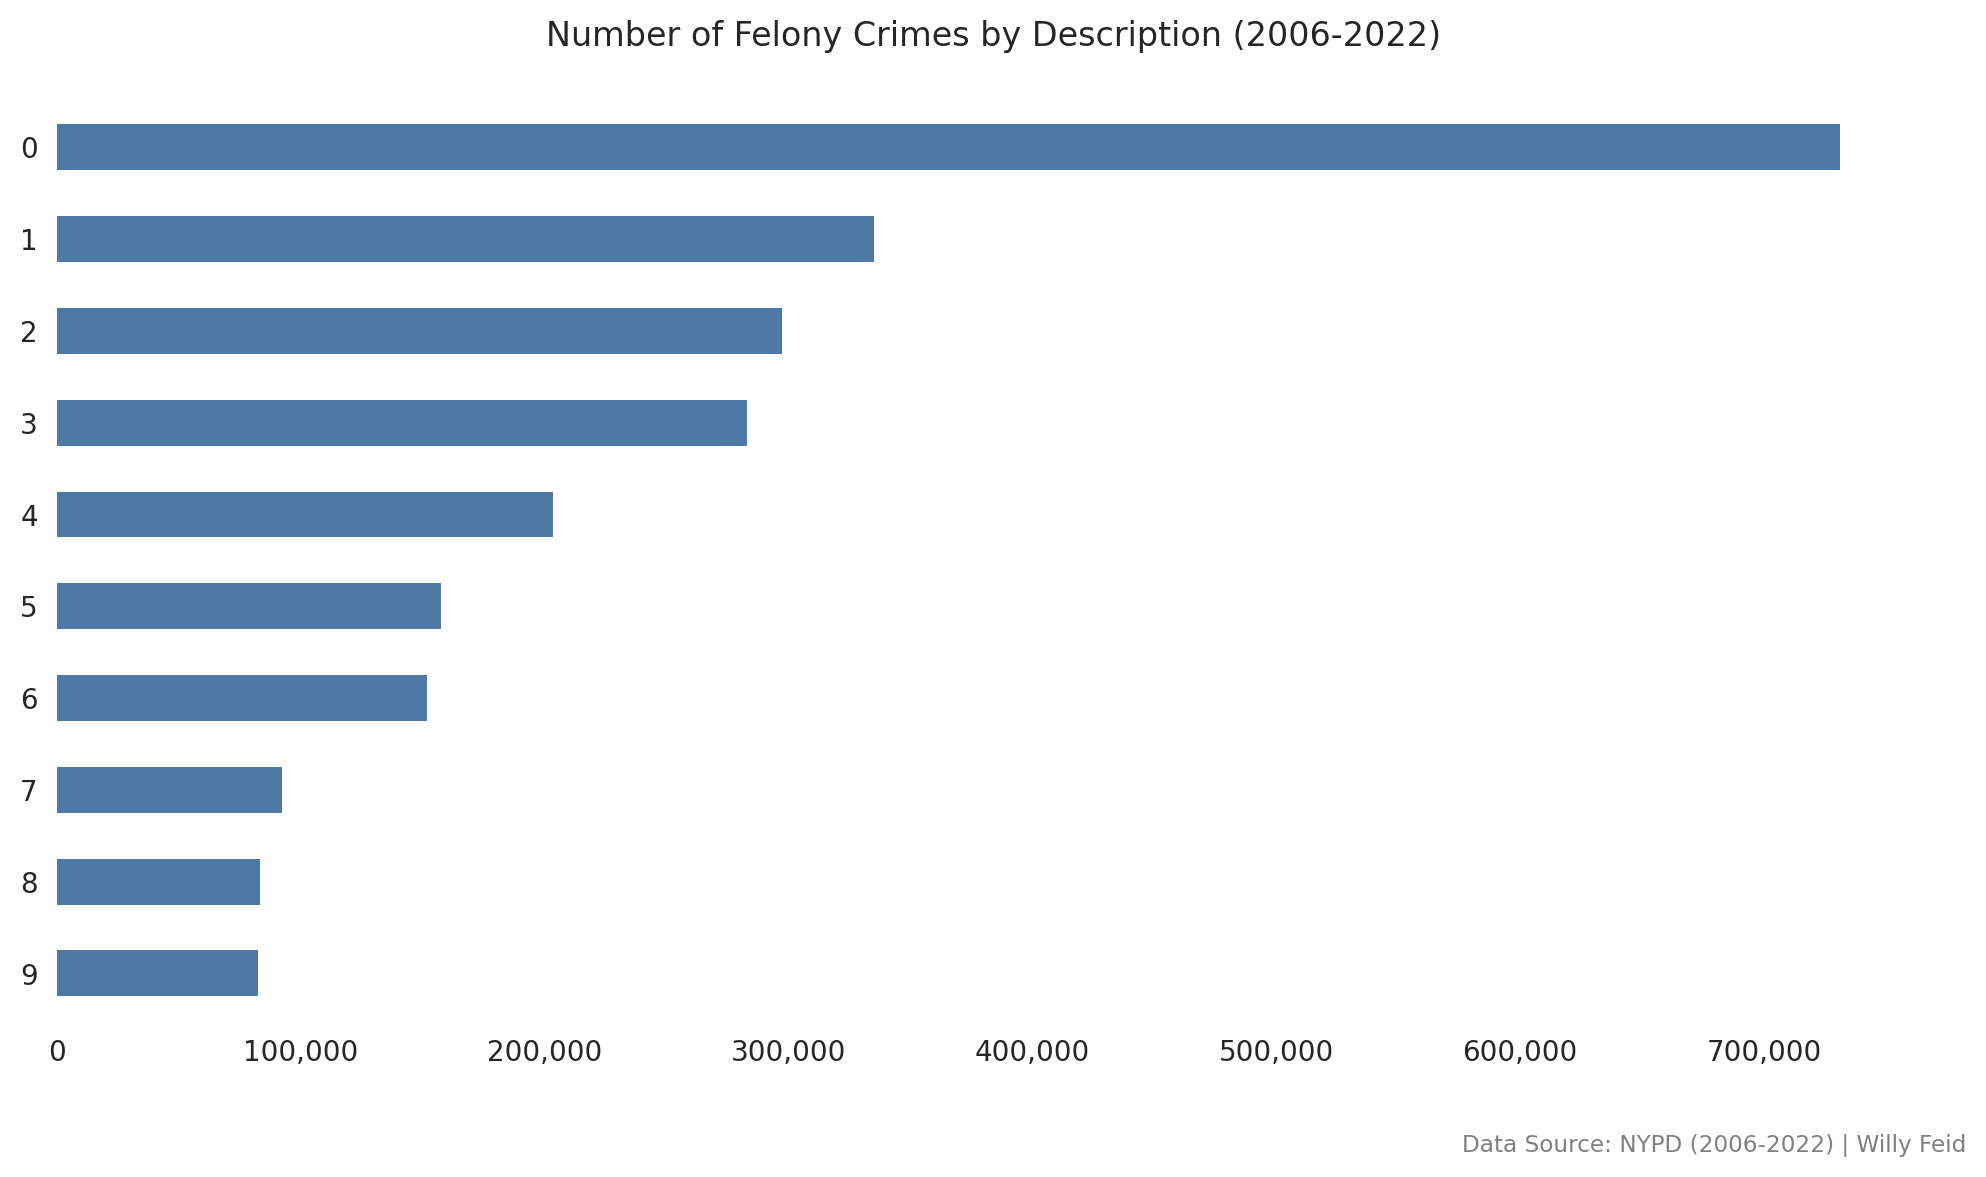

In [160]:
# Plotting felony's by description on horizontal bar

# Set the style
sns.set_style("whitegrid")

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
df3['num_crimes'].sort_values().plot(kind='barh', ax=ax, color=chartcolor, edgecolor='none')

# Removing fig box
for spine in ax.spines.values():
  spine.set_visible(False)

# Function to format x-axis labels with commas
def format_ticks(value, tick_number):
    return f'{value:,.0f}'

ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))

ax.tick_params(bottom=False, left=False)  # Remove the ticks
ax.set_xlabel(" ")
ax.set_ylabel("")
ax.set_title("Number of Felony Crimes by Description (2006-2022)", pad=20)

ax.text(1.02, -0.15, caption_text, transform=ax.transAxes, fontsize='small', color='gray', ha='right', va='bottom')
ax.xaxis.grid(False)
ax.yaxis.grid(False)

plt.tight_layout()

plt.show()

## 2. Trends in crime over time:

  *  Trend in total number of all reported crimes per year.
  *  Trend in total number of all reported crimes per month.

In [161]:
# Total reported Crimes per year

sql = '''
SELECT YEAR(CMPLNT_FR) AS crime_date, COUNT(LAW_CAT_CD) AS num_crimes
FROM nypd
WHERE YEAR(CMPLNT_FR) >= 2006 AND YEAR(CMPLNT_FR) < 2023
GROUP BY YEAR(CMPLNT_FR)
ORDER BY YEAR(CMPLNT_FR);
'''

with engine.connect() as connection:
	df_yr = pd.read_sql(text(sql), con=connection)

df_yr

,crime_date,num_crimes
0,2006,520825
1,2007,528669
2,2008,526689
3,2009,509946
4,2010,507388
5,2011,498136
6,2012,504347
7,2013,495439
8,2014,491730
9,2015,478320


**Plotting Total Crimes by Year**

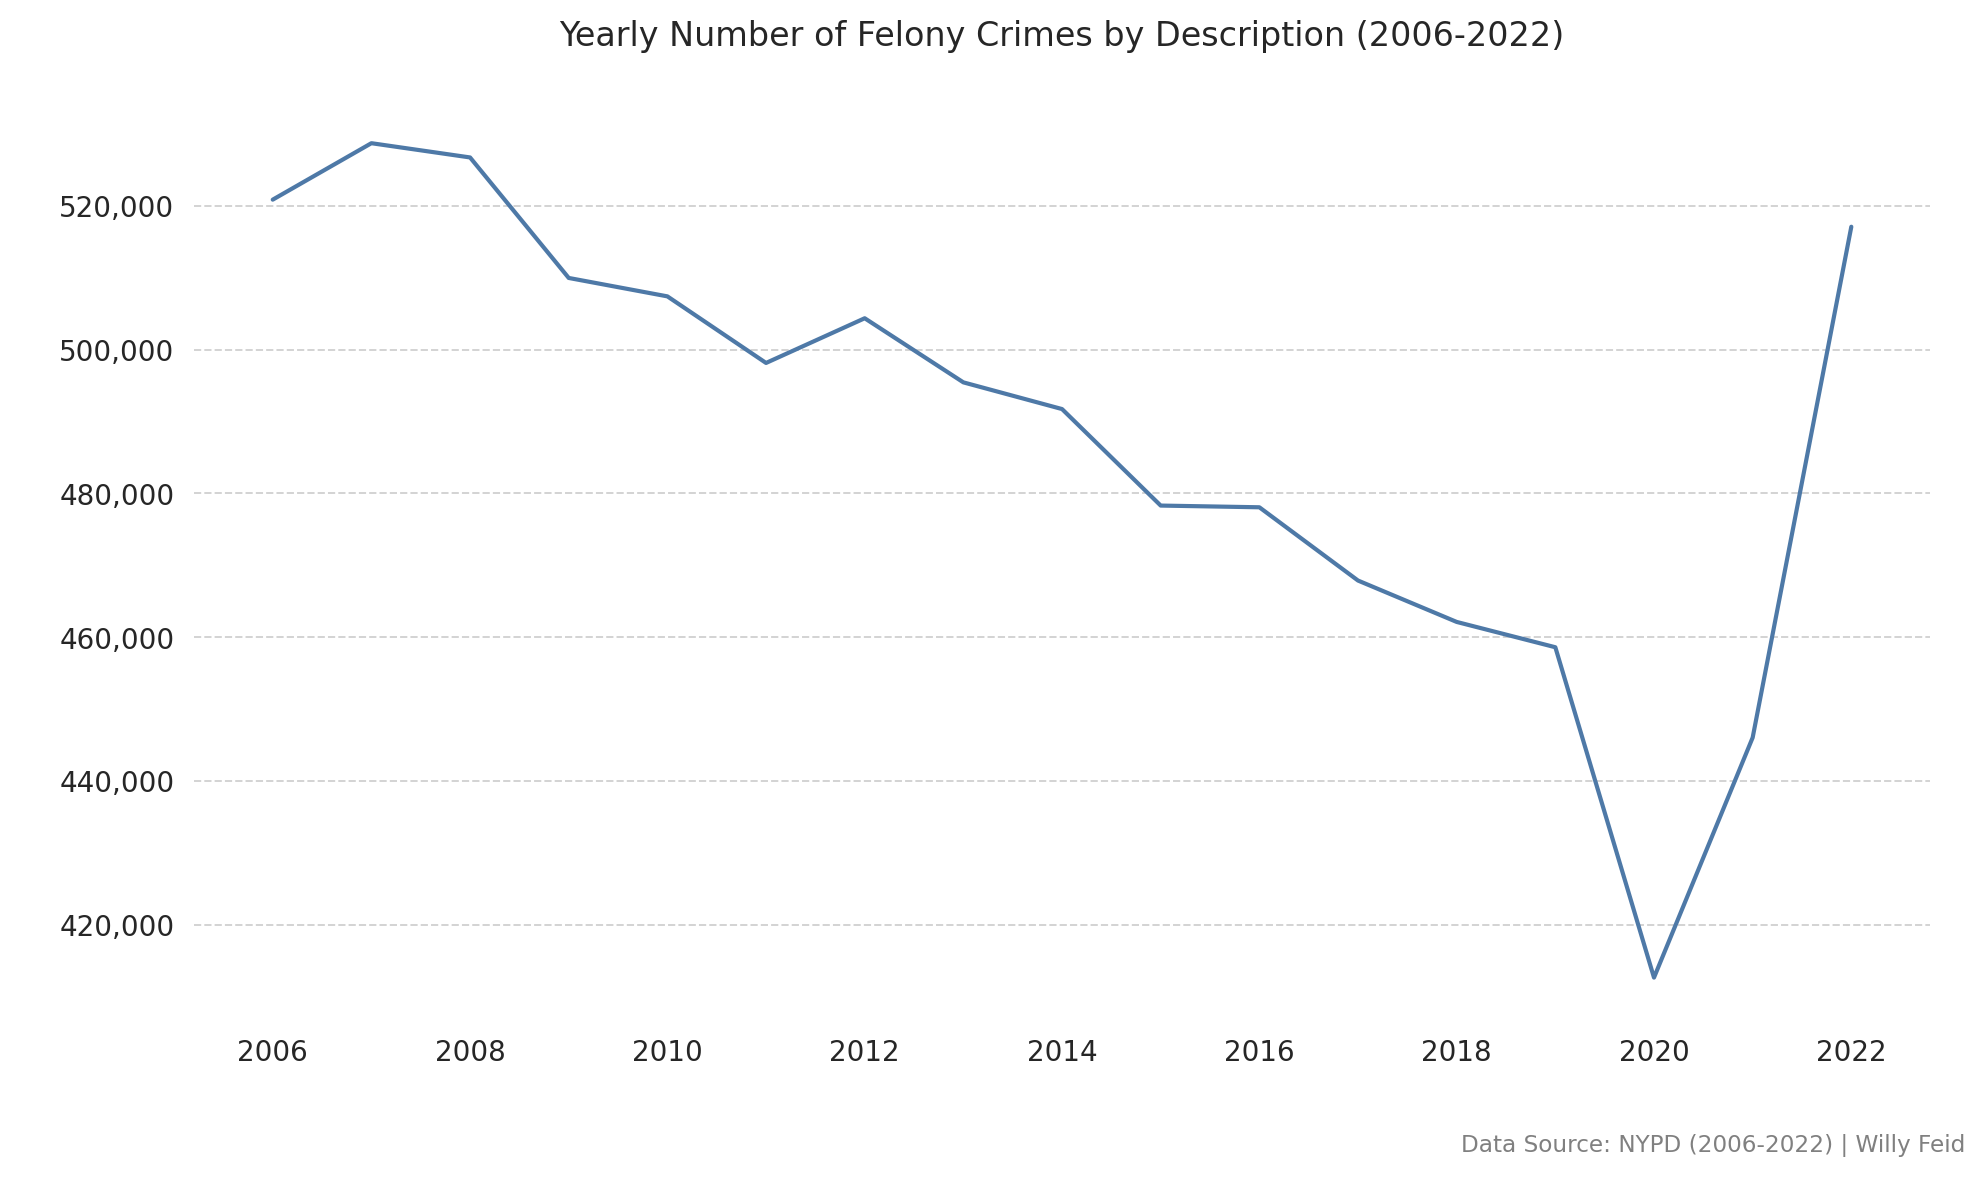

In [162]:
# Plotting crimes by year

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_yr['crime_date'], df_yr['num_crimes'], color=chartcolor)

# Removing fig box
for spine in ax.spines.values():
  spine.set_visible(False)

# Using format_ticks function created earlier to add commas to y values
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Titles and formatting
ax.tick_params(bottom=False, left=False)  # Remove the ticks
ax.set_xlabel(" ")
ax.set_ylabel(" ")
ax.set_title("Yearly Number of Felony Crimes by Description (2006-2022)", pad=20)

ax.text(1.02, -0.15, caption_text, transform=ax.transAxes, fontsize='small', color='gray', ha='right', va='bottom')
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle="--", linewidth=0.7, color='lightgray')

plt.tight_layout()

plt.show()

**Plotting Total Crimes by Month**

In [163]:
# Monthly total crimes
sql = '''
SELECT DATE_FORMAT(CMPLNT_FR, '%Y-%m') AS crime_month, COUNT(LAW_CAT_CD) AS num_crimes
FROM nypd
WHERE CMPLNT_FR >= '2006-01-01' AND CMPLNT_FR < '2023-01-01'
GROUP BY DATE_FORMAT(CMPLNT_FR, '%Y-%m')
ORDER BY DATE_FORMAT(CMPLNT_FR, '%Y-%m');
'''

with engine.connect() as connection:
	df_mo = pd.read_sql(text(sql), con=connection)



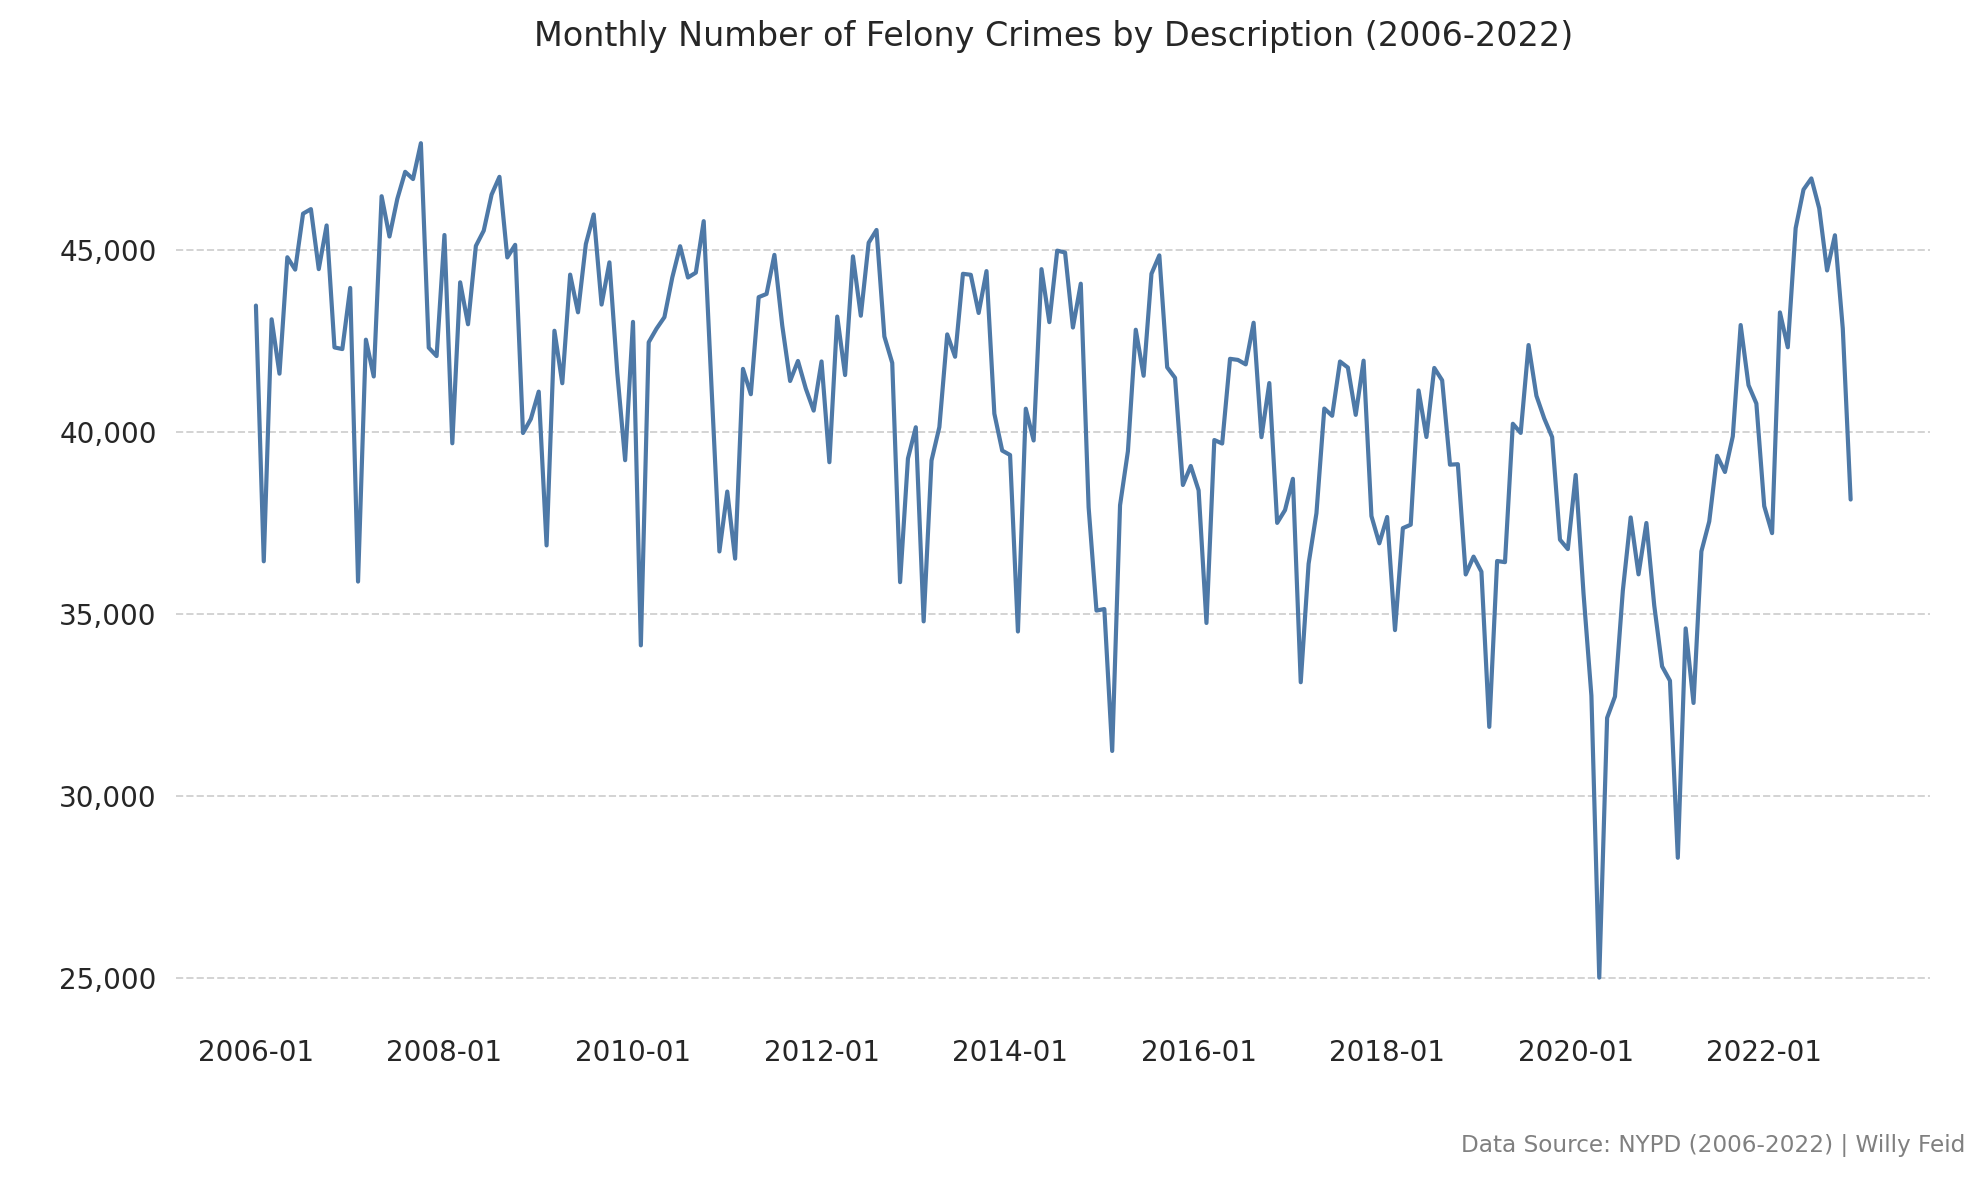

In [164]:
# Plotting crimes by month

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_mo['crime_month'], df_mo['num_crimes'], color=chartcolor)

# Set x-tick labels to only show every 24th month
x_ticks = ax.get_xticks()
x_labels = [label if (i % 24 == 0) else '' for i, label in enumerate(df_mo['crime_month'])]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)


# Removing fig box
for spine in ax.spines.values():
  spine.set_visible(False)

# Using format_ticks function created earlier to add commas to y values
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Titles and formatting
ax.tick_params(bottom=False, left=False)  # Remove the ticks
ax.set_xlabel(" ")
ax.set_ylabel(" ")
ax.set_title("Monthly Number of Felony Crimes by Description (2006-2022)", pad=20)

ax.text(1.02, -0.15, caption_text, transform=ax.transAxes, fontsize='small', color='gray', ha='right', va='bottom')
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle="--", linewidth=0.7, color='lightgray')

plt.tight_layout()

plt.show()

## 3. Analysis of the major felonies.
  * The major felonies are: Grand Larceny, Robbery, Felony Assault, Burglary, Grand Larceny of Motor Vehicle, Rape.
  * Reporting the number of these crimes over time broken down by felony type.


In [170]:
# Getting the Major felony types
sql = '''
SELECT t.crime_month, t.OFNS_DESC, t.num_crimes
FROM (
    SELECT DATE_FORMAT(CMPLNT_FR, '%Y-%m') AS crime_month, OFNS_DESC, COUNT(LAW_CAT_CD) AS num_crimes
    FROM offense_codes
        LEFT JOIN nypd ON offense_codes.KY_CD = nypd.KY_CD
    WHERE LAW_CAT_CD = 'FELONY'
        AND OFNS_DESC IN ('GRAND LARCENY', 'ROBBERY', 'FELONY ASSAULT', 'BURGLARY', 'GRAND LARCENY OF MOTOR VEHICLE', 'RAPE')
        AND CMPLNT_FR >= '2006-01-01' AND CMPLNT_FR < '2023-01-01'
    GROUP BY DATE_FORMAT(CMPLNT_FR, '%Y-%m'), OFNS_DESC
) AS t
ORDER BY t.crime_month, t.OFNS_DESC;
'''

with engine.connect() as connection:
	df_7 = pd.read_sql(text(sql), con=connection)


# Creating Pivot table:
pivot2 = pd.pivot_table(
    data=df_7,
    index="crime_month",
    columns="OFNS_DESC",
    values="num_crimes"
#    ,aggfunc="count"
)


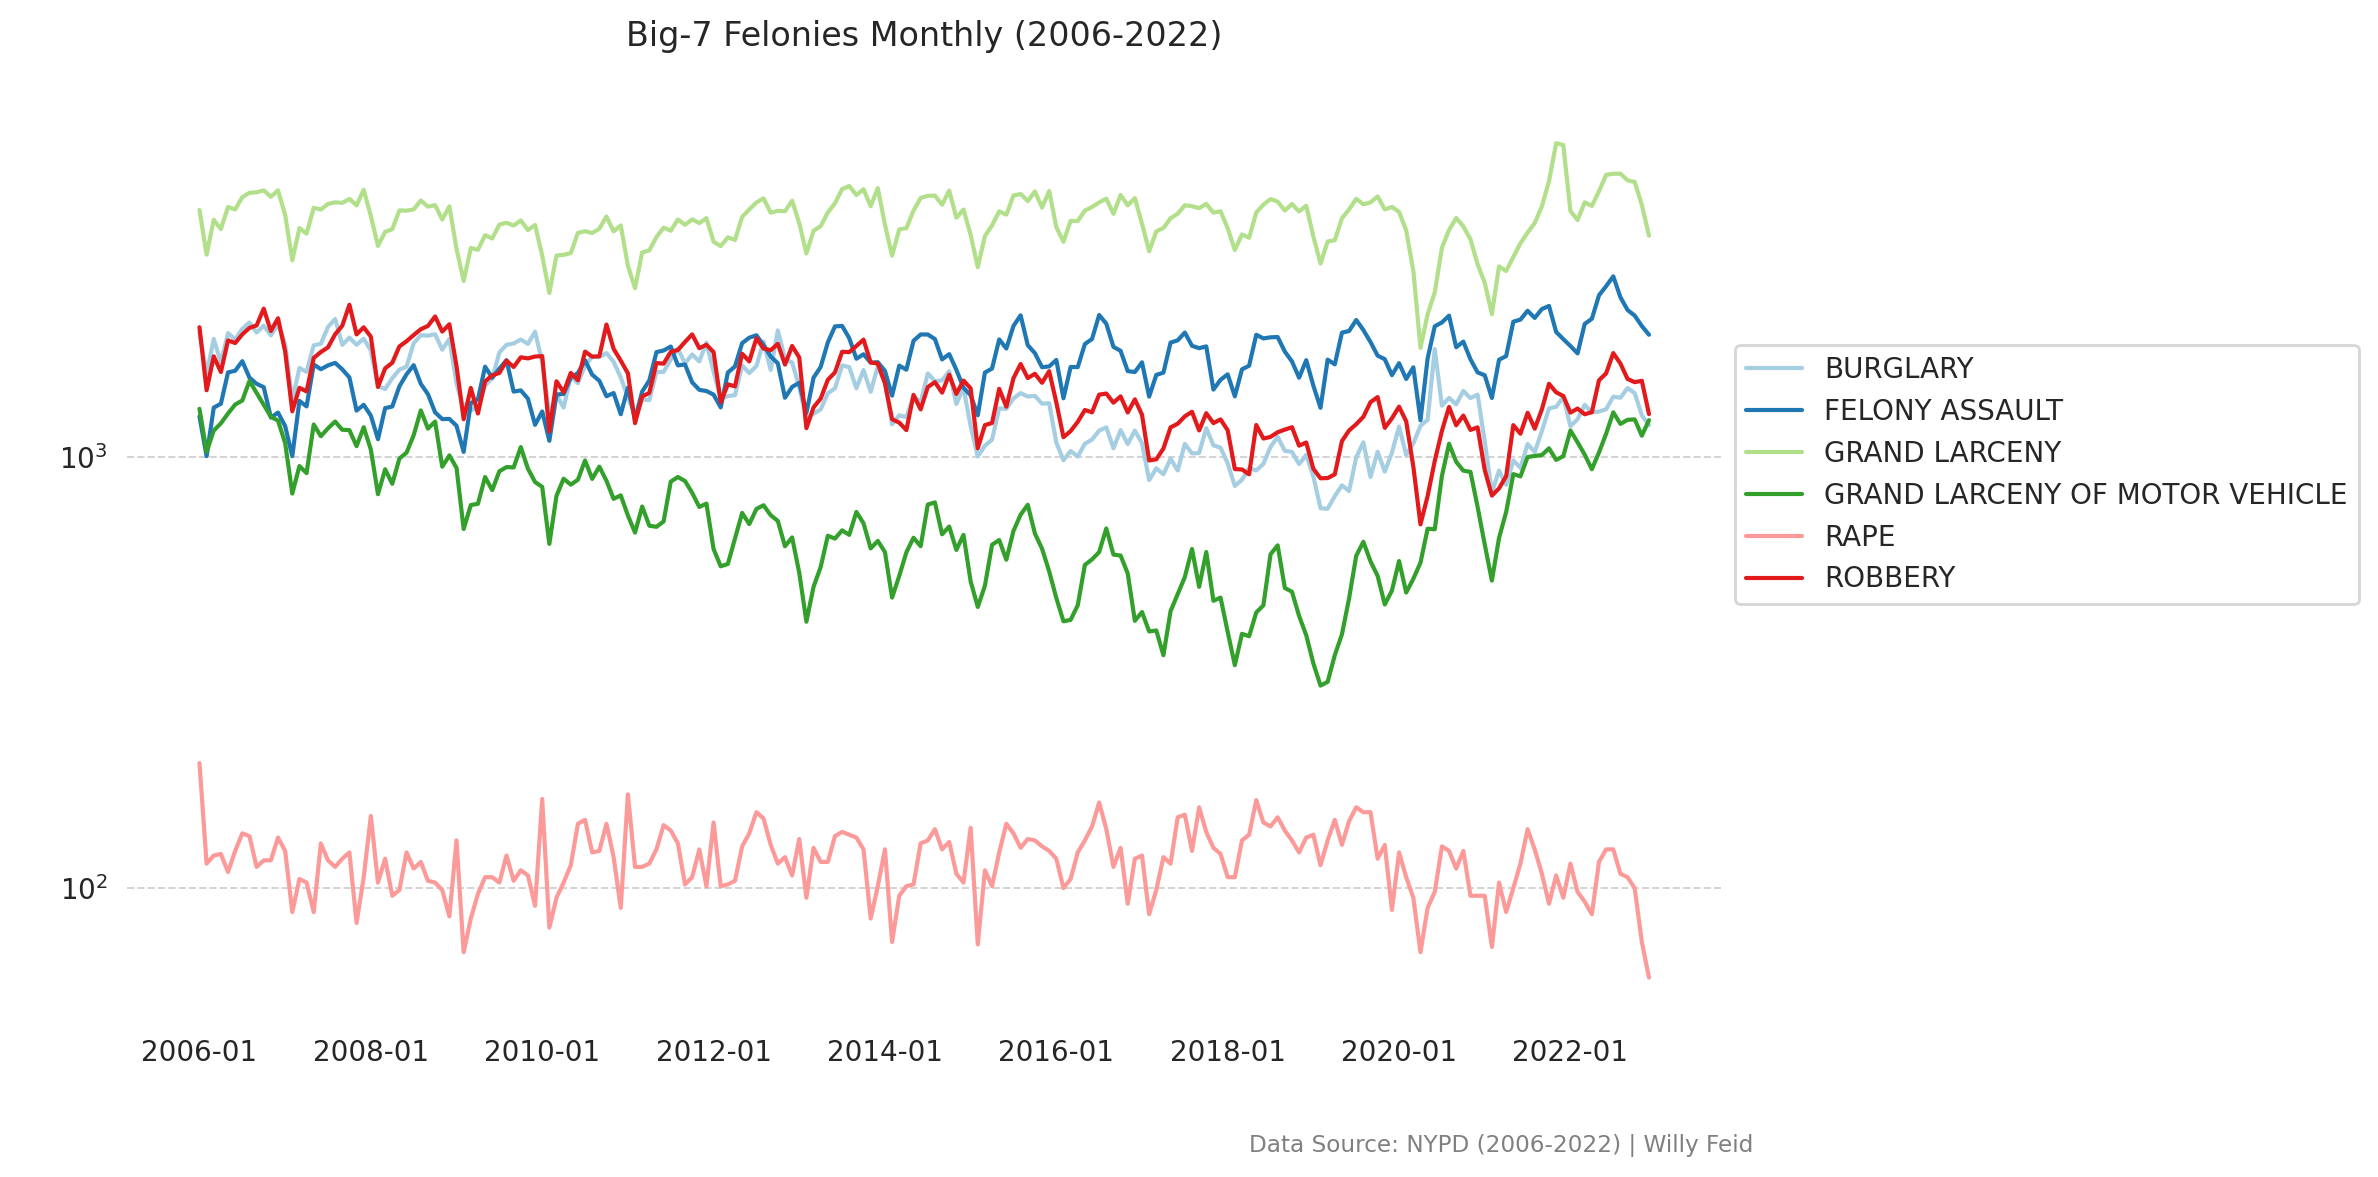

In [171]:
# Plotting Major Felonies in Monthly frequency

color_palette = sns.color_palette("Paired")
sns.set_style("whitegrid")

# Only temporarilly setting pallette
with sns.color_palette(color_palette):
    fig, ax = plt.subplots(figsize=(12, 6))
    for column in pivot2.columns:
        ax.plot(pivot2.index, pivot2[column], label=column)

# Set log scale for y-axis
ax.set_yscale('log')

# Set x-tick labels to only show every 24th month
x_ticks = ax.get_xticks()
x_labels = [label if (i % 24 == 0) else '' for i, label in enumerate(df_mo['crime_month'])]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)


# Removing fig box
for spine in ax.spines.values():
  spine.set_visible(False)


# Titles and formatting
ax.tick_params(bottom=False, left=False)  # Remove the ticks
ax.set_xlabel(" ")
ax.set_ylabel(" ")
ax.set_title("Big-7 Felonies Monthly (2006-2022)", pad=20)
ax.legend(bbox_to_anchor=(1, 0.75))
ax.text(1.02, -0.15, caption_text, transform=ax.transAxes, fontsize='small', color='gray', ha='right', va='bottom')
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle="--", linewidth=0.7, color='lightgray')

plt.tight_layout()

plt.show()

## 4. The Major felonies based on hour of the day.
  * The major felonies by hour of the day.
  * The major felonies by hour, Normalized to allow for easier comparison.


In [172]:
# Getting felonies by the hour of the day
sql = '''
SELECT t.crime_hour, t.OFNS_DESC, t.num_crimes
FROM (
    SELECT DATE_FORMAT(CMPLNT_FR, '%H') AS crime_hour, OFNS_DESC, COUNT(LAW_CAT_CD) AS num_crimes
    FROM offense_codes
        LEFT JOIN nypd ON offense_codes.KY_CD = nypd.KY_CD
    WHERE LAW_CAT_CD = 'FELONY'
        AND OFNS_DESC IN ('GRAND LARCENY', 'ROBBERY', 'FELONY ASSAULT', 'BURGLARY', 'GRAND LARCENY OF MOTOR VEHICLE', 'RAPE')
        AND CMPLNT_FR >= '2006-01-01' AND CMPLNT_FR < '2023-01-01'
    GROUP BY DATE_FORMAT(CMPLNT_FR, '%H'), OFNS_DESC
) AS t
ORDER BY t.crime_hour, t.OFNS_DESC;
'''

with engine.connect() as connection:
	df_hr = pd.read_sql(text(sql), con=connection)

#Creating a Pivot Table:
pivot_df = pd.pivot_table(
    data=df_hr,
    index="crime_hour",
    columns="OFNS_DESC",
    values="num_crimes"
#    ,aggfunc="count"
)


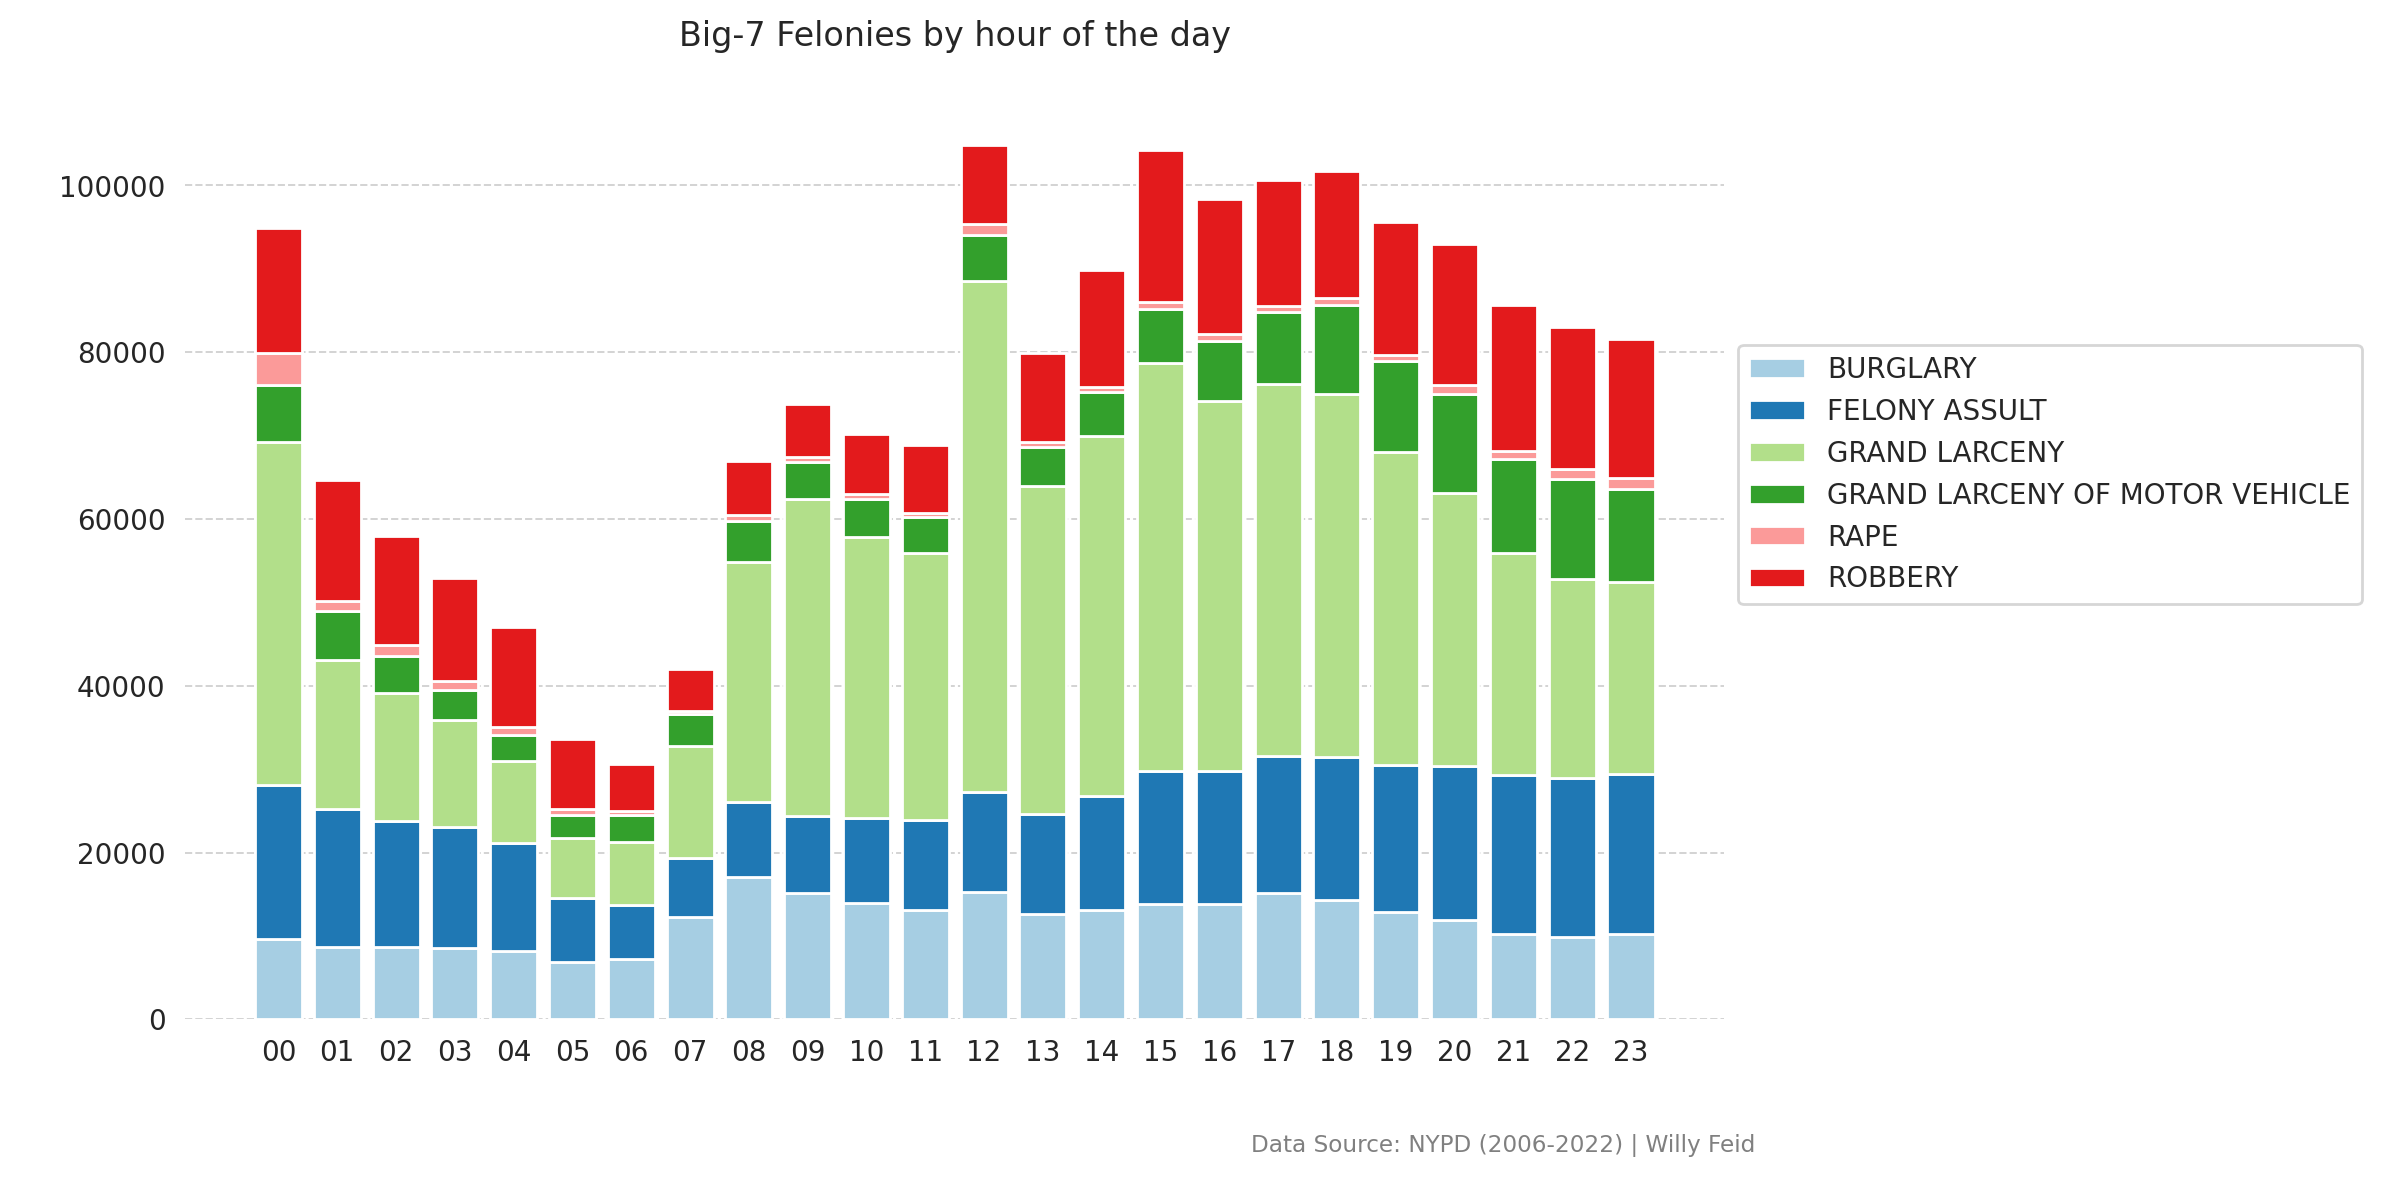

In [173]:
# Plotting Major Felonies by hour in the day

color_palette = sns.color_palette("Paired")
sns.set_style("whitegrid")

# Only temporarilly setting pallette
with sns.color_palette(color_palette):
    fig, ax = plt.subplots(figsize=(12, 6))
    #for column in pivot_df.columns:
     #   ax.bar(pivot_df.index, pivot_df[column], label=column)
    ax.bar(pivot_df.index, pivot_df['BURGLARY'], label="BURGLARY")
    ax.bar(pivot_df.index, pivot_df['FELONY ASSAULT'], bottom=pivot_df['BURGLARY'], label="FELONY ASSULT")
    ax.bar(pivot_df.index, pivot_df['GRAND LARCENY'], bottom=pivot_df['BURGLARY'] + pivot_df['FELONY ASSAULT'], label="GRAND LARCENY")
    ax.bar(pivot_df.index, pivot_df['GRAND LARCENY OF MOTOR VEHICLE'],
           bottom=pivot_df['BURGLARY'] + pivot_df['FELONY ASSAULT'] + pivot_df['GRAND LARCENY'], label="GRAND LARCENY OF MOTOR VEHICLE")
    ax.bar(pivot_df.index, pivot_df['RAPE'],
           bottom=pivot_df['BURGLARY'] + pivot_df['FELONY ASSAULT'] + pivot_df['GRAND LARCENY']
           + pivot_df['GRAND LARCENY OF MOTOR VEHICLE'], label="RAPE")
    ax.bar(pivot_df.index, pivot_df['ROBBERY'],
           bottom=pivot_df['BURGLARY'] + pivot_df['FELONY ASSAULT'] + pivot_df['GRAND LARCENY']
           + pivot_df['GRAND LARCENY OF MOTOR VEHICLE'] + pivot_df['RAPE'], label="ROBBERY")

# Removing fig box
for spine in ax.spines.values():
  spine.set_visible(False)


# Titles and formatting
ax.tick_params(bottom=False, left=False)  # Remove the ticks
ax.set_xlabel(" ")
ax.set_ylabel(" ")
ax.set_title("Big-7 Felonies by hour of the day", pad=20)
ax.legend(bbox_to_anchor=(1, 0.75))
ax.text(1.02, -0.15, caption_text, transform=ax.transAxes, fontsize='small', color='gray', ha='right', va='bottom')
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle="--", linewidth=0.7, color='lightgray')

plt.tight_layout()

plt.show()

**Normalizing data and plotting felonies by hor of the day**

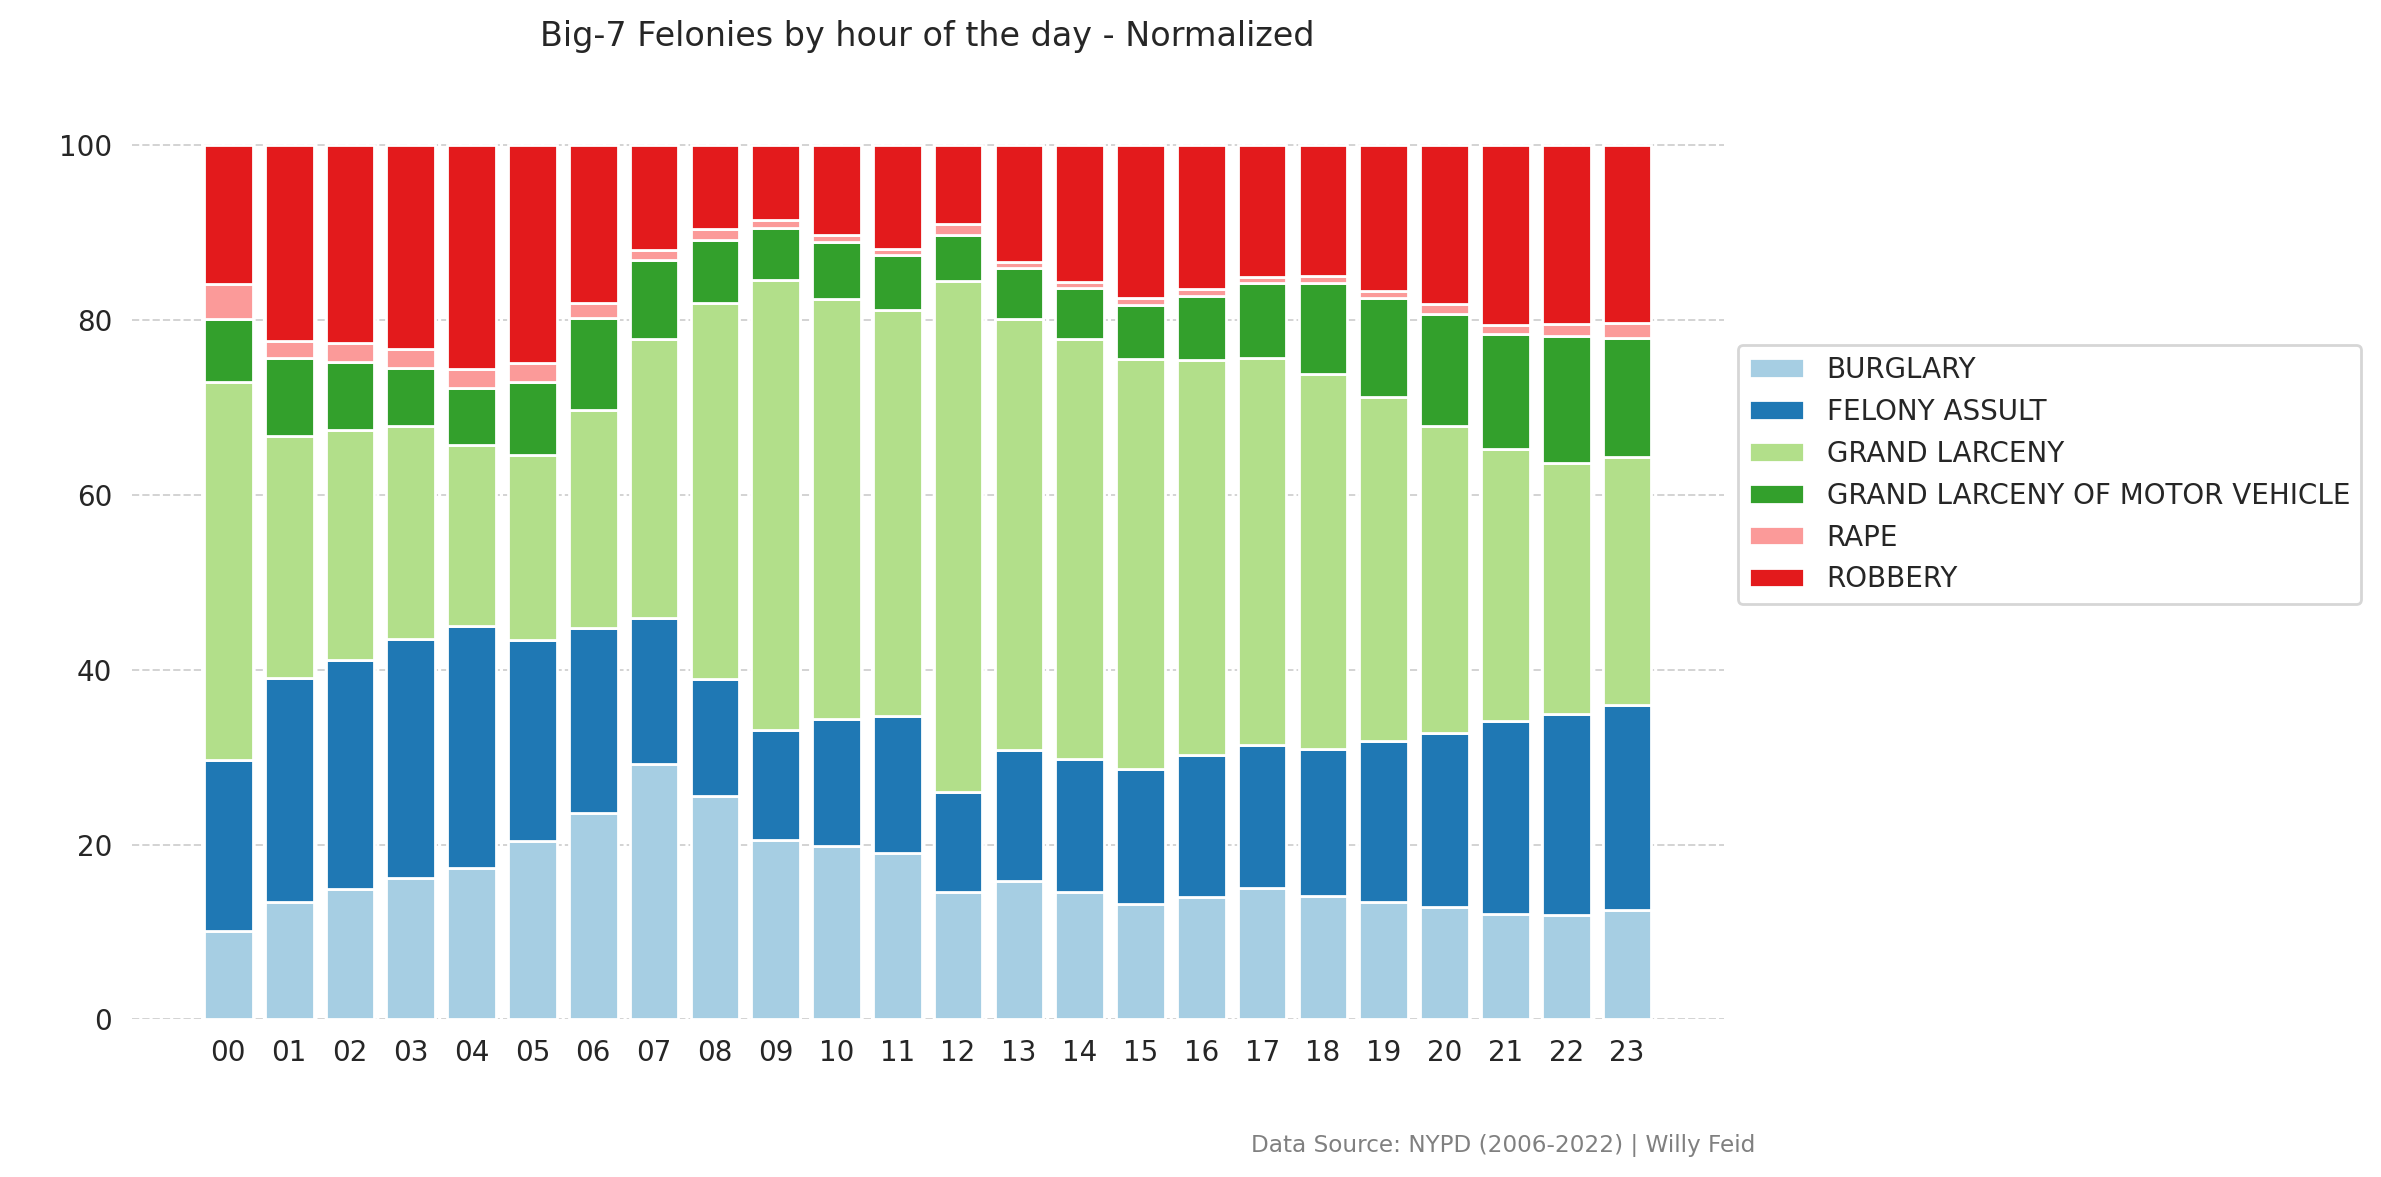

In [174]:
# Normalizing the date:

# calculate the totals:
felony_totals = pivot_df.sum(axis=1)

# divide the data by the total
normalized_df = pivot_df.divide(felony_totals, axis=0) * 100
normalized_df = normalized_df.round(2)

# Plotting results
with sns.color_palette(color_palette):
    fig, ax = plt.subplots(figsize=(12, 6))
    #for column in pivot_df.columns:
     #   ax.bar(pivot_df.index, pivot_df[column], label=column)
    ax.bar(normalized_df.index, normalized_df['BURGLARY'], label="BURGLARY")
    ax.bar(normalized_df.index, normalized_df['FELONY ASSAULT'], bottom=normalized_df['BURGLARY'], label="FELONY ASSULT")
    ax.bar(normalized_df.index, normalized_df['GRAND LARCENY'], bottom=normalized_df['BURGLARY'] + normalized_df['FELONY ASSAULT'], label="GRAND LARCENY")
    ax.bar(normalized_df.index, normalized_df['GRAND LARCENY OF MOTOR VEHICLE'],
           bottom=normalized_df['BURGLARY'] + normalized_df['FELONY ASSAULT'] + normalized_df['GRAND LARCENY'], label="GRAND LARCENY OF MOTOR VEHICLE")
    ax.bar(normalized_df.index, normalized_df['RAPE'],
           bottom=normalized_df['BURGLARY'] + normalized_df['FELONY ASSAULT'] + normalized_df['GRAND LARCENY']
           + normalized_df['GRAND LARCENY OF MOTOR VEHICLE'], label="RAPE")
    ax.bar(normalized_df.index, normalized_df['ROBBERY'],
           bottom=normalized_df['BURGLARY'] + normalized_df['FELONY ASSAULT'] + normalized_df['GRAND LARCENY']
           + normalized_df['GRAND LARCENY OF MOTOR VEHICLE'] + normalized_df['RAPE'], label="ROBBERY")

# Removing fig box
for spine in ax.spines.values():
  spine.set_visible(False)


# Titles and formatting
ax.tick_params(bottom=False, left=False)  # Remove the ticks
ax.set_xlabel(" ")
ax.set_ylabel(" ")
ax.set_title("Big-7 Felonies by hour of the day - Normalized", pad=20)
ax.legend(bbox_to_anchor=(1, 0.75))
ax.text(1.02, -0.15, caption_text, transform=ax.transAxes, fontsize='small', color='gray', ha='right', va='bottom')
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle="--", linewidth=0.7, color='lightgray')

plt.tight_layout()

plt.show()

### 5. Spacial Analysis
  * Where in NYC are these crimes being committed?
  * Density plot (over NYC map) for each major felony.

Analyzing the spatial density for the following types of felonies:

* GRAND LARCENY
* ROBBERY
* FELONY ASSAULT
* BURGLARY
* GRAND LARCENY OF MOTOR VEHICLE


In [175]:
# NYC neighborhood coordinates

# Dataset from NYC Open Data: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas/cpf4-rkhq
!curl 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON' -o nyc-neighborhoods.geojson

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4372k    0 4372k    0     0  1447k      0 --:--:--  0:00:03 --:--:-- 1447k


<Axes: >

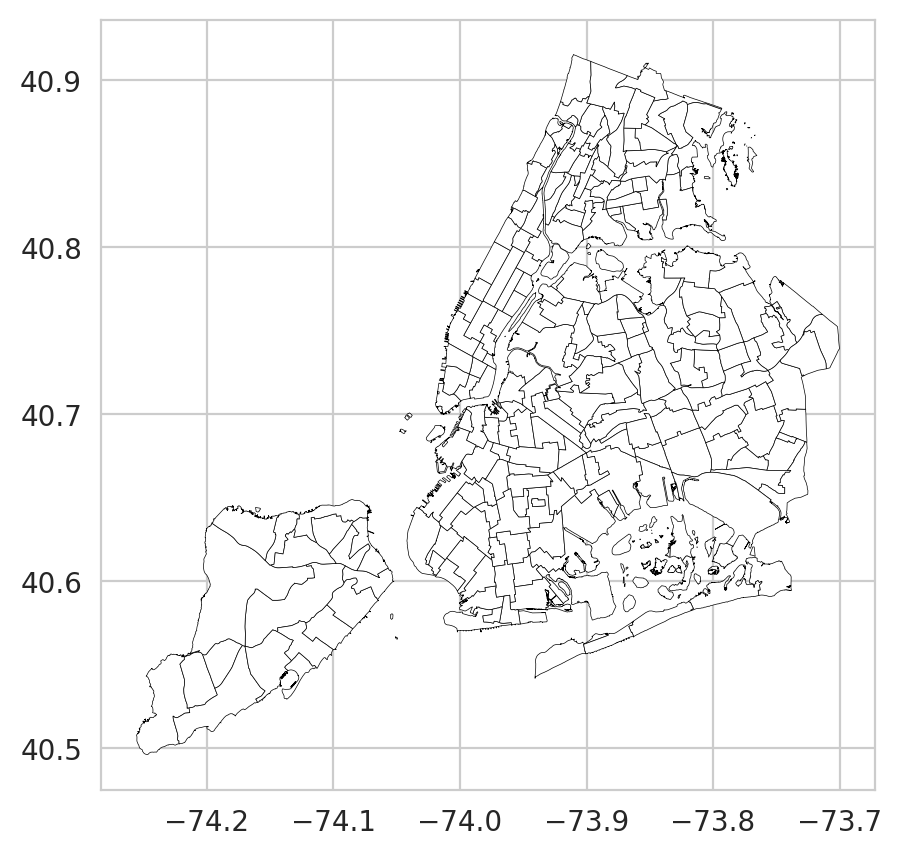

In [176]:
# Loading the shapefile
df_nyc = gpd.GeoDataFrame.from_file('nyc-neighborhoods.geojson')

# View the map
df_nyc.plot(linewidth=0.25, color='White', edgecolor='Black', figsize=(5, 5))

In [177]:
# Getting reports from these felonies that have longitude and latitude data.
sql = '''
SELECT Latitude, Longitude, OFNS_DESC, COUNT(LAW_CAT_CD) AS num_crimes
FROM offense_codes
	LEFT JOIN nypd ON offense_codes.KY_CD = nypd.KY_CD
WHERE LAW_CAT_CD = 'FELONY'
	AND OFNS_DESC IN ('GRAND LARCENY', 'ROBBERY', 'FELONY ASSAULT', 'BURGLARY', 'GRAND LARCENY OF MOTOR VEHICLE')
	AND YEAR(CMPLNT_FR) = 2022
    AND Latitude IS NOT NULL
    AND Longitude IS NOT NULL
GROUP BY OFNS_DESC, Latitude, Longitude
ORDER BY OFNS_DESC;
'''


with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)


In [178]:
#Creating dataframes with each felony type for plotting:
gl_df = df[df['OFNS_DESC'] == 'GRAND LARCENY']
robbery_df = df[df['OFNS_DESC'] == 'ROBBERY']
f_assault_df = df[df['OFNS_DESC'] == 'FELONY ASSAULT']
burglary_df = df[df['OFNS_DESC'] == 'BURGLARY']
gl_mv_df = df[df['OFNS_DESC'] == 'GRAND LARCENY OF MOTOR VEHICLE']


In [182]:
# Setting up a 3 by 3 grid for density plots

# Function to apply common styling
def format_plot(ax, title):
    ax.set_title(title)
    ax.grid(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)


# Create 3 by 3 subplot
fig, axs = plt.subplots(2, 3, figsize=(16, 8))

# List of dataframes and titles
data_info = [
    (gl_df, 'Grand Larceny'),
    (robbery_df, 'Robbery'),
    (f_assault_df, 'Felony Assault'),
    (burglary_df, 'Burglary'),
    (gl_mv_df, 'Grand Larceny of Motor Vehicle'),
    (df, 'All Felonies')
]

# Looping over dataframes and corresponding titles
for idx, (data_df, title) in enumerate(data_info):
    # Calculate the position of the current plot
    row, col = divmod(idx, 3)
    base = df_nyc.plot(
        linewidth=0.5,
        color='White',
        edgecolor='Black',
        alpha=0.6,
        ax=axs[row, col]
    )

    scatter = data_df.plot(
        kind='scatter',
        x='Longitude',
        y='Latitude',
        s=1,
        alpha=0.5,
        ax=base
    )

    sns.kdeplot(
        data=data_df,
        x='Longitude',
        y='Latitude',
        gridsize=100,
        cmap='rainbow',
        fill=True,
        alpha=0.3,
        thresh=0.01,
        n_levels=50,
        ax=scatter
    )

    # Apply formatting function
    format_plot(axs[row, col], title)

plt.tight_layout()

plt.show()


Output hidden; open in https://colab.research.google.com to view.